In [1]:
import torch
from torchvision import transforms, models
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
classes = ['Cristiano Ronaldo',
           'Erling Haaland',
           'Kylian Mbappe',
           'Lionel Messi',
           'Neymar Jr']

In [4]:
def load_model(weights_path):
    model = models.resnet18(weights = "IMAGENET1K_V1")
    size_of_last_layer = model.fc.in_features
    model.fc = nn.Linear(size_of_last_layer, len(classes))
    model.load_state_dict(torch.load(weights_path))
    model = model.to(device)
    return model

In [5]:
model = load_model("../models/TL_CNN_model_weights.pth")

In [6]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

In [7]:
def crop_photo(image_path):
    image = cv2.imread(image_path)
    faces = face_cascade.detectMultiScale(image)
    for (x, y, w, h) in faces:
        roi_color = image[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_color)
        if len(eyes) >= 2:
            return roi_color

In [8]:
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Normalize(mean = torch.tensor([0.485, 0.456, 0.406]), std = torch.tensor([0.229, 0.224, 0.225]))
])

In [9]:
softmax = nn.Softmax(dim = 1)

In [15]:
def predict(image_path):
    cropped_image = crop_photo(image_path)
    
    if cropped_image is None:
        print("Please enter a photo in which a football athlete's face and both eyes are properly visible")
        return None
        
    image = cv2.imread(image_path)
        
    fig, ax = plt.subplots(1, 2, figsize = (7, 7))
    
    # displaying original image
    ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[0].set_title("Original Image")
    
    # displaying cropped image
    ax[1].imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
    ax[1].set_title("Cropped Image for prediction")

    for axes in ax:
        axes.axis("off")

    plt.show()

    # transforming image for prediction
    transformed_image = image_transform(cropped_image).unsqueeze(0)

    model.eval()

    # getting predictions
    with torch.no_grad():
        output = softmax(model(transformed_image))
        probabilities = {classes[i]: round(output[0, i].item(), 3) for i in range(len(classes))}
        value, prediction = torch.max(output, 1)
    print(f"As the probability of {value.item():.3f} is highest among all so the the football athlete in the picture is {classes[prediction]}")
    return probabilities

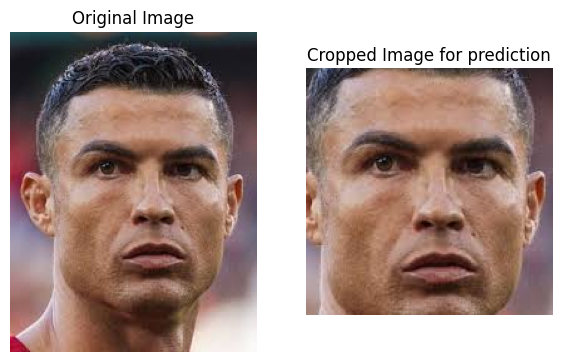

As the probability of 0.346 is highest among all so the the football athlete in the picture is Cristiano Ronaldo


{'Cristiano Ronaldo': 0.346,
 'Erling Haaland': 0.232,
 'Kylian Mbappe': 0.063,
 'Lionel Messi': 0.242,
 'Neymar Jr': 0.117}

In [16]:
predict("./images/4.jpeg")

In [12]:
# for image in os.scandir("./images/"):
#     print(f"Image path: {image.path}\n")
#     print(predict(image.path))
#     print()

In [12]:
f"There were total 300 raw images in my test dataset out of which only 63 images contained face and both eyes of a particular football athelete properly and out of those 63 pictures my model predicted 49 correct so my model's accuracy on test dataset is {round(((49 / 63) * 100), 3)}%"

"There were total 300 raw images in my test dataset out of which only 63 images contained face and both eyes of a particular football athelete properly and out of those 63 pictures my model predicted 49 correct so my model's accuracy on test dataset is 77.778%"